# MNE ↔ SPM Interoperability: Auditory MEG Preprocessing Pipeline

This notebook demonstrates a pipeline to:
1. Load MEG data using [MNE](https://mne.tools/stable/index.html)
2. Convert it to [SPM](https://www.fil.ion.ucl.ac.uk/spm/) format for preprocessing
3. Convert it back to MNE format
4. Perform additional analysis in MNE

---

### Preamble
Install MNE and ensure you have the latest version of SPM Python

In [ ]:
%pip install mne
%pip install -U spm-python 

Import useful packages.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mne

plt.ion();  # interactive mode on

---

### 0. Import spm

In [ ]:
from spm.utils import spm_2_mne_raw, mne_raw_2_spm
from spm import spm_opm_amm, Struct

---

### 1. Read in the data using MNE

This step loads the raw MEG data file for the selected subject using MNE, preparing it for visualization and preprocessing.

In [ ]:
# Define the subject and session identifier
subject = "sub-002"
session = "ses-001"

# Get the path to the example OPM auditory dataset
data_path = mne.datasets.ucl_opm_auditory.data_path()

# Construct the path to the MEG binary file for the subject
opm_file = (
    data_path
    / subject
    / session
    / "meg"
    / f"{subject}_{session}_task-aef_run-001_meg.bin"
)

# Set the path to the FreeSurfer subjects directory (for anatomical data)
subjects_dir = data_path / "derivatives" / "freesurfer" / "subjects"

# Read the raw MEG data using MNE's FIL reader
raw = mne.io.read_raw_fil(opm_file, verbose="error")

# Crop the data to the time window 120s to 210s and load it into memory
raw.crop(120, 210).load_data()

Reading 0 ... 540000  =      0.000 ...    90.000 secs...


<RawFIL | sub-002_ses-001_task-aef_run-001_meg.bin, 95 x 540001 (90.0 s), ~391.5 MiB, data loaded>

### 2. Plot raw data using MNE

This section visualizes the raw MEG data before any preprocessing, allowing us to inspect the signal quality and identify potential artifacts.

In [ ]:
# Pick MEG channels from the raw data
picks = mne.pick_types(raw.info, meg=True)

# Scale factor to convert Tesla to picoTesla
amp_scale = 1e12  # T->pT

# Define the stopping index to exclude the last 300 time points
stop = len(raw.times) - 300

# Downsampling step size
step = 300

# Extract a subset of MEG channels (every 5th channel) and time points up to 'stop'
data_ds, time_ds = raw[picks[::5], :stop]

# Further downsample the data in time and convert amplitude to picoTesla
data_ds, time_ds = data_ds[:, ::step] * amp_scale, time_ds[::step]

Lets plot some of the data before processing. 

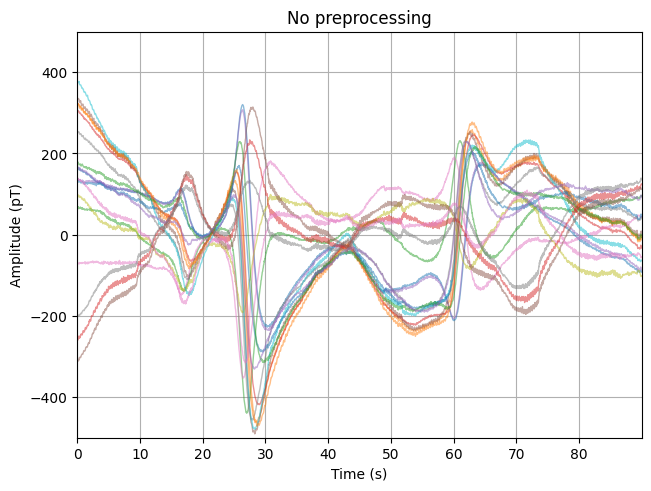

In [ ]:
fig, ax = plt.subplots(layout="constrained")
plot_kwargs = dict(lw=1, alpha=0.5)
offset_data = data_ds.T - np.mean(data_ds, axis=1)
ax.plot(time_ds, offset_data, **plot_kwargs)
ax.grid(True)
ax.set(
    title="No preprocessing",
    ylim=(-500, 500),
    xlim=(time_ds[0], time_ds[-1]),
    xlabel="Time (s)",
    ylabel="Amplitude (pT)",
)
plt.show()

Effective window size : 4.000 (s)
Plotting amplitude spectral density (dB=True).


C:\Users\jmsno\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


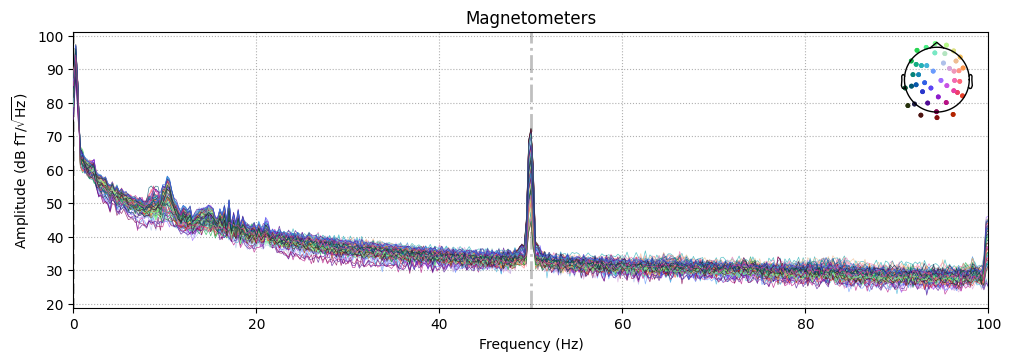

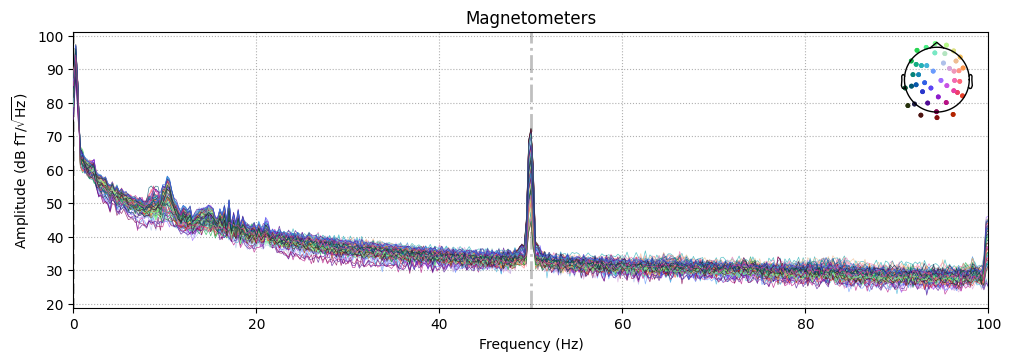

In [ ]:
psd_kwargs = dict(fmax=100, n_fft=int(round(raw.info["sfreq"]) * 2 * 2))
raw.compute_psd(**psd_kwargs).plot(dB=True, amplitude=True)

### 3. Some preprocessing using MNE

The following cells apply basic preprocessing steps to the raw MEG data, including notch filtering, band-pass filtering, and marking bad channels.

In [ ]:
# Apply notch filtering at 50, 100, 150, 200, and 250 Hz to remove power line noise and its harmonics
raw.notch_filter(np.arange(50, 251, 50), notch_widths=4)

# Apply band-pass filtering between 1 and 70 Hz to MEG channels
raw.filter(1, 70, picks="meg")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 39601 samples (6.600 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwid

<RawFIL | sub-002_ses-001_task-aef_run-001_meg.bin, 95 x 540001 (90.0 s), ~391.5 MiB, data loaded>

In [ ]:
# Mark all reference magnetometer channels as bad
ref_mag_name = [
    ch["ch_name"]
    for ch in raw.info["chs"]
    if ch["kind"] == mne.io.constants.FIFF.FIFFV_REF_MEG_CH
]
raw.info["bads"] = ref_mag_name

# Add specific channels to the list of bad channels
raw.info["bads"].extend(["G2-A4-RAD", "G2-17-TAN"])

### 4. MNE 2 SPM

This converts the preprocessed MEG data from MNE format into SPM format, and saves it in the current directory.

In [ ]:
# Convert the preprocessed MNE Raw object to SPM format and save in the current directory
data = mne_raw_2_spm(raw, ".")
data

Initializing Matlab Runtime...


### 5. SPM processing

This is equivalent to the following MATLAB code:
```matlab
S = [];
S.D = data;
mD = spm_opm_amm(S);
```
which applies AMM to the data.

In [ ]:
S = Struct()
S.D = data
mD = spm_opm_amm(S)

### 6. SPM 2 MNE

Convert the processed data back to MNE. 

In [12]:
cleaned_data = spm_2_mne_raw(mD)
cleaned_data

Creating RawArray with float64 data, n_channels=95, n_times=540001
    Range : 0 ... 540000 =      0.000 ...    90.000 secs
Ready.


<RawArray | 95 x 540001 (90.0 s), ~391.5 MiB, data loaded>

### 7. MNE plotting

Show the effect of preprocessing. 

Effective window size : 4.000 (s)
Plotting amplitude spectral density (dB=True).


C:\Users\jmsno\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


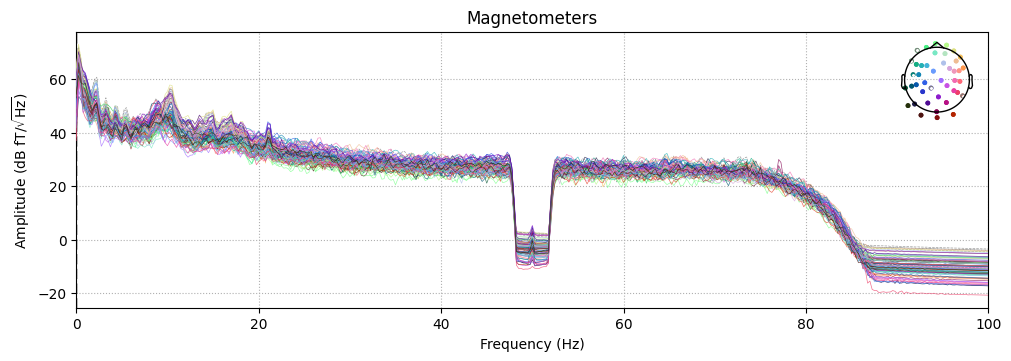

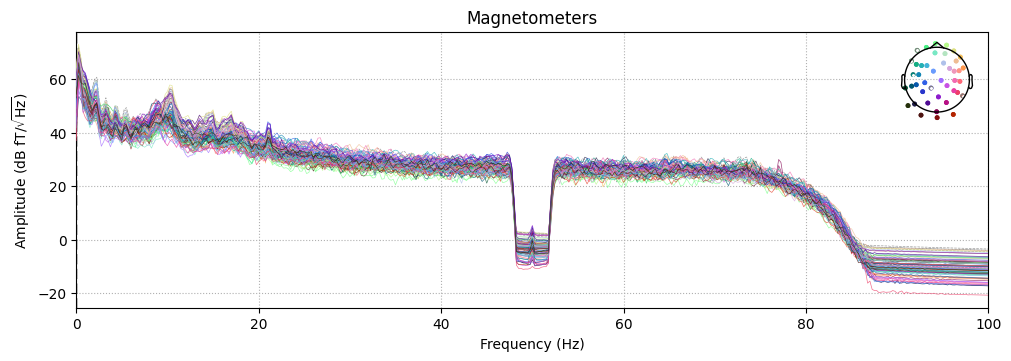

In [13]:
psd_kwargs = dict(fmax=100, n_fft=int(round(cleaned_data.info["sfreq"]) * 2 * 2))
cleaned_data.compute_psd(**psd_kwargs).plot(dB=True, amplitude=True)

In [ ]:
# Pick MEG channels from the cleaned data
picks = mne.pick_types(cleaned_data.info, meg=True)

# Scale factor to convert Tesla to picoTesla
amp_scale = 1e12  # T->pT

# Define the stopping index to exclude the last 300 time points
stop = len(cleaned_data.times) - 300

# Downsampling step size
step = 300

# Extract a subset of MEG channels (every 5th channel) and time points up to 'stop'
data_ds, time_ds = cleaned_data[picks[::5], :stop]

# Further downsample the data in time and convert amplitude to picoTesla
data_ds, time_ds = data_ds[:, ::step] * amp_scale, time_ds[::step]

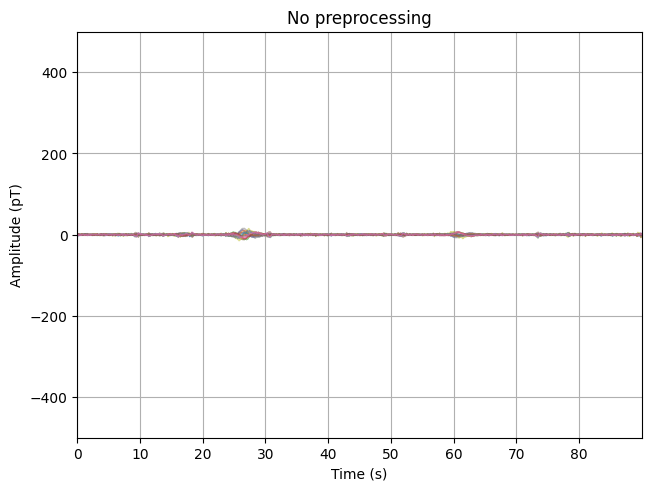

In [ ]:
fig, ax = plt.subplots(layout="constrained")
plot_kwargs = dict(lw=1, alpha=0.5)
offset_data = data_ds.T - np.mean(data_ds, axis=1)
ax.plot(time_ds, offset_data, **plot_kwargs)
ax.grid(True)
ax.set(
    title="No preprocessing",
    ylim=(-500, 500),
    xlim=(time_ds[0], time_ds[-1]),
    xlabel="Time (s)",
    ylabel="Amplitude (pT)",
)
plt.show()

### 8. MNE epoching

In this section, we'll extract events from the cleaned MEG data and create epochs around those events. We'll then average the epochs to obtain evoked responses, and visualize the results for different sensor types. This helps us see how the brain responds to auditory stimuli after preprocessing and artifact removal.

In [ ]:
# Find events in the cleaned MEG data using the 'NI-TRIG' stimulus channel
# Only consider events with a minimum duration of 1 ms
events = mne.find_events(cleaned_data, stim_channel="NI-TRIG", min_duration=0.001)

# Define a dictionary mapping event names to event IDs
events_dict = {"trigger": 3}

# Apply a band-pass filter between 2 and 40 Hz to the MEG channels in the cleaned data
cleaned_data.filter(2, 40, picks="meg")

# Create epochs around the detected events in the cleaned MEG data
# - tmin and tmax define the time window around each event (-100 ms to 400 ms)
# - event_id specifies which events to use
# - detrend=1 applies linear detrending to each epoch
# - baseline correction is applied from -50 ms to 0 ms
# - preload=True loads the data into memory for faster access
epochs = mne.Epochs(
    cleaned_data,
    events,
    tmin=-0.1,
    tmax=0.4,
    event_id=events_dict,
    detrend=1,
    baseline=[-0.05, 0],
    preload=True,
)

180 events found on stim channel NI-TRIG
Event IDs: [3]


Compute and plot the evoked responses.

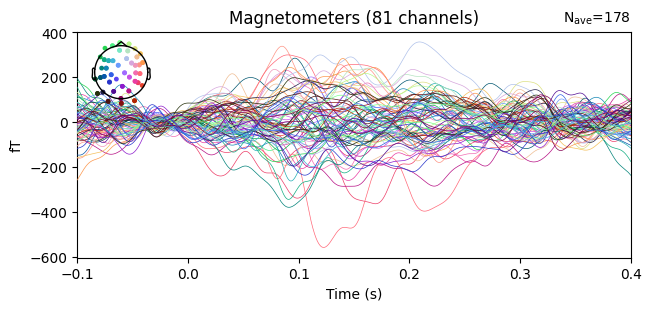

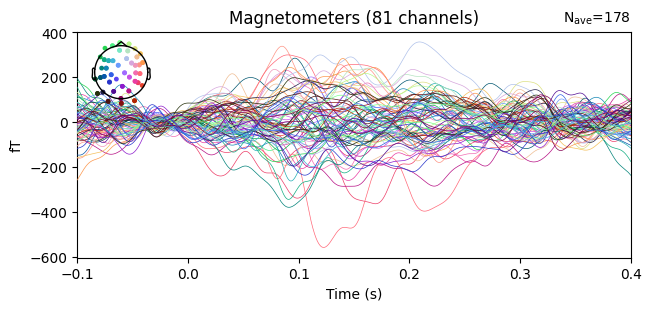

In [ ]:
evoked = epochs["trigger"].average()
evoked.plot()

Show the evoked response over the radial sensors.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Projections have already been applied. Setting proj attribute to True.


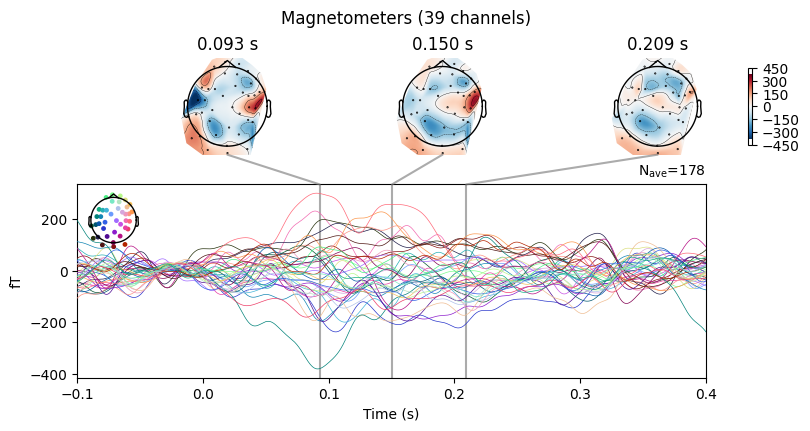

In [ ]:
# Select all channels whose names end with 'RAD' (radial sensors)
radial_channels = [ch for ch in evoked.ch_names if ch.endswith("RAD")]

# Pick only the radial channels from the evoked data
evoked_radial = evoked.pick_channels(radial_channels)

# Plot the joint view (time series + topomap) for the radial sensors
fig = evoked_radial.plot_joint()

Show the evoked response over the tangential sensors.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Projections have already been applied. Setting proj attribute to True.


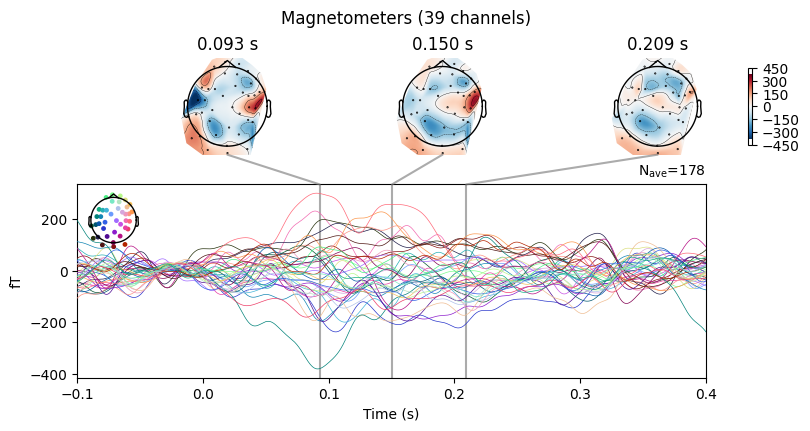

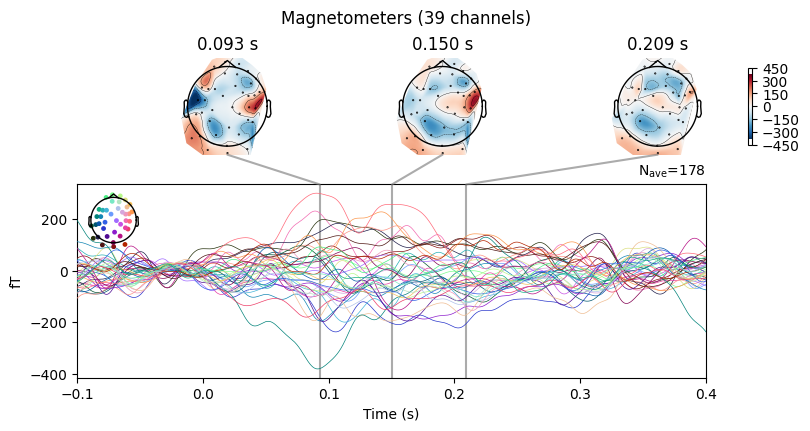

In [ ]:
# Select all channels whose names end with 'TAN' (tangential sensors)
tang_channels = [ch for ch in evoked.ch_names if ch.endswith("TAN")]

# Pick only the tangential channels from the evoked data
evoked_tang = evoked.pick_channels(tang_channels)

# Plot the joint view (time series + topomap) for the tangential sensors
evoked_tang.plot_joint()